<a href="https://colab.research.google.com/github/DeqingSun/Machine-Learning-Experiment-on-8-bit-Arduino/blob/master/Machine_Learning_Experiment_on_8_bit_Arduino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Experiment on 8-bit Arduino

###Deqing Sun

This project try to export and run Keras model to 8-bit Arduino, without using any ML library.

The original project uses TFLite library, which is too heavy for 8-bit Arduino such as Arduino Uno or Leonardo : https://colab.research.google.com/github/arduino/ArduinoTensorFlowLiteTutorials/blob/master/GestureToEmoji/arduino_tinyml_workshop.ipynb

#The following code is almost identical to reference, with some tweak on parameters to make model smaller. 

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import math

In [2]:
!wget -nv -r -O flex.csv https://raw.githubusercontent.com/DeqingSun/Machine-Learning-Experiment-on-8-bit-Arduino/master/sampleData/flex.csv
!wget -nv -r -O punch.csv https://raw.githubusercontent.com/DeqingSun/Machine-Learning-Experiment-on-8-bit-Arduino/master/sampleData/punch.csv

will be placed in the single file you specified.

2020-05-09 05:24:34 URL:https://raw.githubusercontent.com/DeqingSun/Machine-Learning-Experiment-on-8-bit-Arduino/master/sampleData/flex.csv [4523/4523] -> "flex.csv" [1]
FINISHED --2020-05-09 05:24:34--
Total wall clock time: 0.4s
Downloaded: 1 files, 4.4K in 0s (55.3 MB/s)
will be placed in the single file you specified.

2020-05-09 05:24:37 URL:https://raw.githubusercontent.com/DeqingSun/Machine-Learning-Experiment-on-8-bit-Arduino/master/sampleData/punch.csv [4376/4376] -> "punch.csv" [1]
FINISHED --2020-05-09 05:24:37--
Total wall clock time: 0.4s
Downloaded: 1 files, 4.3K in 0s (39.2 MB/s)


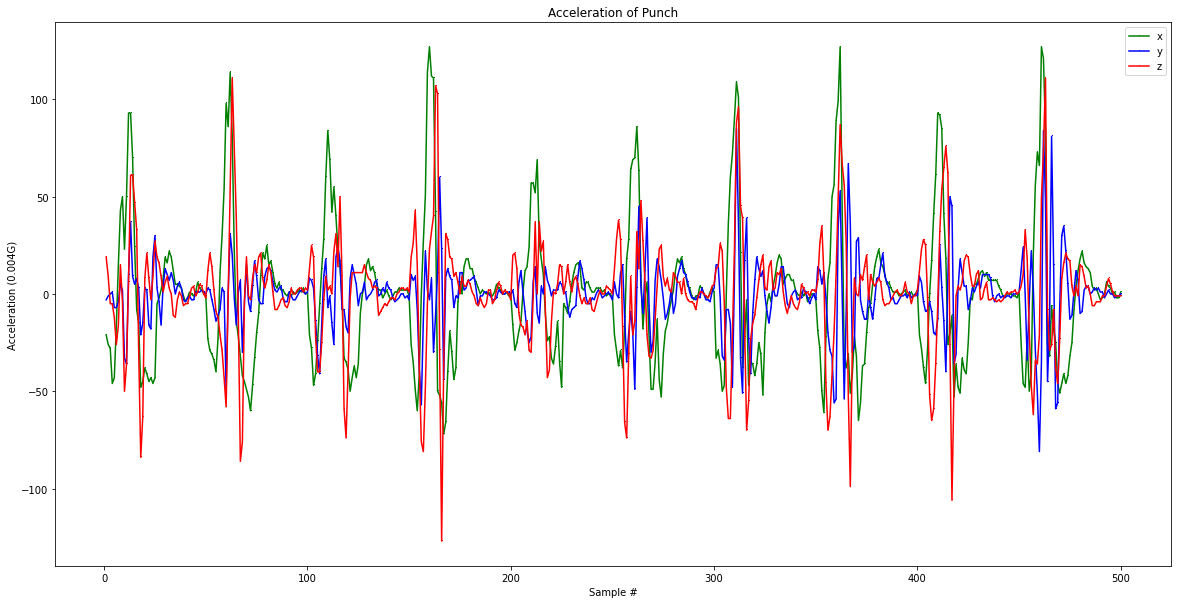

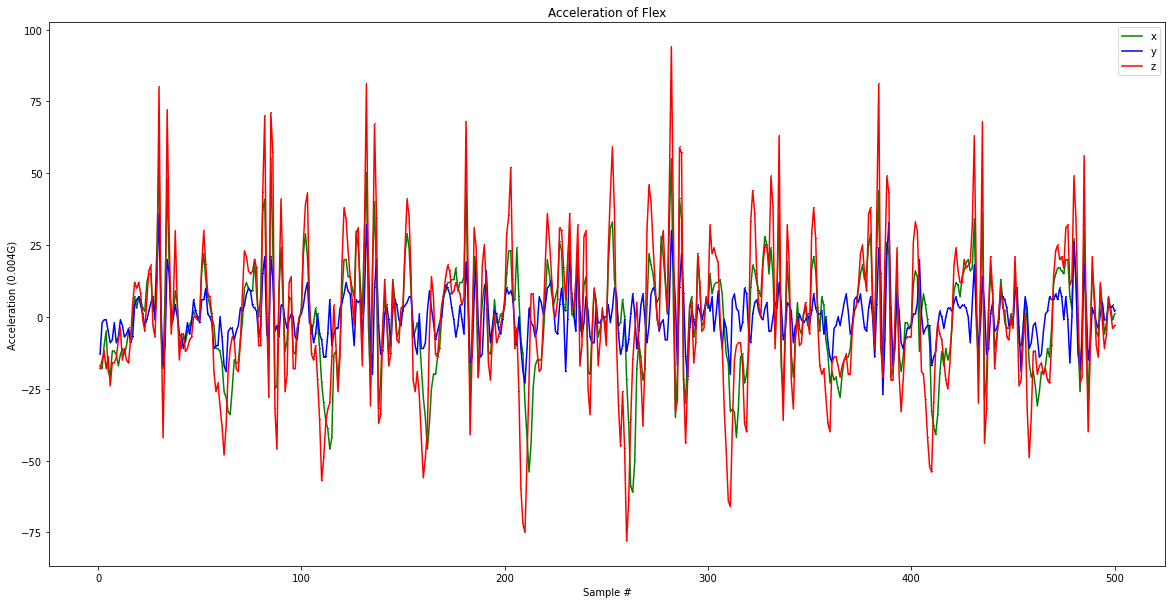

In [3]:
punchData = pd.read_csv("/content/" + "punch.csv")

index = range(1, len(punchData['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, punchData['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, punchData['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, punchData['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration of Punch")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (0.004G)")
plt.legend()
plt.show()


flexData = pd.read_csv("/content/" + "flex.csv")

index = range(1, len(flexData['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, flexData['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, flexData['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, flexData['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration of Flex")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (0.004G)")
plt.legend()
plt.show()

In [4]:
# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "punch",
    "flex",
]

SAMPLES_PER_GESTURE = 50

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 127) / 256,
          (df['aY'][index] + 127) / 256,
          (df['aZ'][index] + 127) / 256,
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

Processing index 0 for gesture 'punch'.
	There are 10 recordings of the punch gesture.
Processing index 1 for gesture 'flex'.
	There are 10 recordings of the flex gesture.
Data set parsing and preparation complete.


In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [6]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation='relu',input_shape=(SAMPLES_PER_GESTURE*3,))) # relu is used for performance
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/200
12/12 [==============================] - 0s 15ms/step - loss: 0.2582 - mae: 0.5053 - val_loss: 0.2493 - val_mae: 0.4977
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2539 - mae: 0.5016 - val_loss: 0.2481 - val_mae: 0.4970
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2524 - mae: 0.5013 - val_loss: 0.2480 - val_mae: 0.4971
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2517 - mae: 0.5009 - val_loss: 0.2469 - val_mae: 0.4961
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2509 - mae: 0.5003 - val_loss: 0.2462 - val_mae: 0.4955
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.2499 - mae: 0.4990 - val_loss: 0.2452 - val_mae: 0.4945
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2495 - mae: 0.4982 - val_loss: 0.2449 - val_mae: 0.4944
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 0.2485 - 

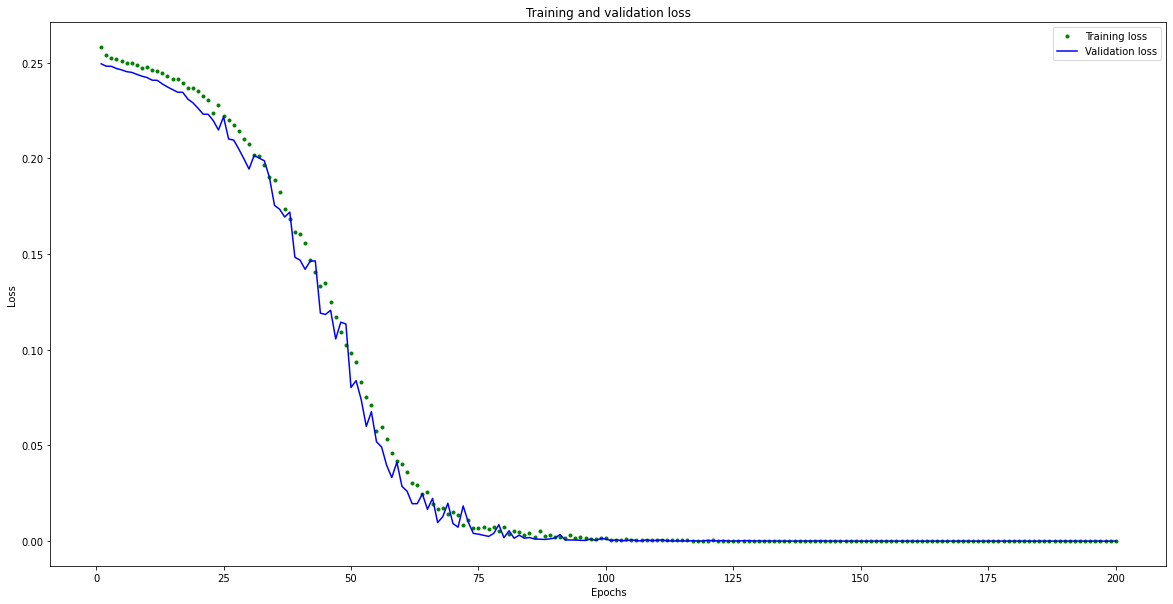

[20.0, 10.0]


In [7]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

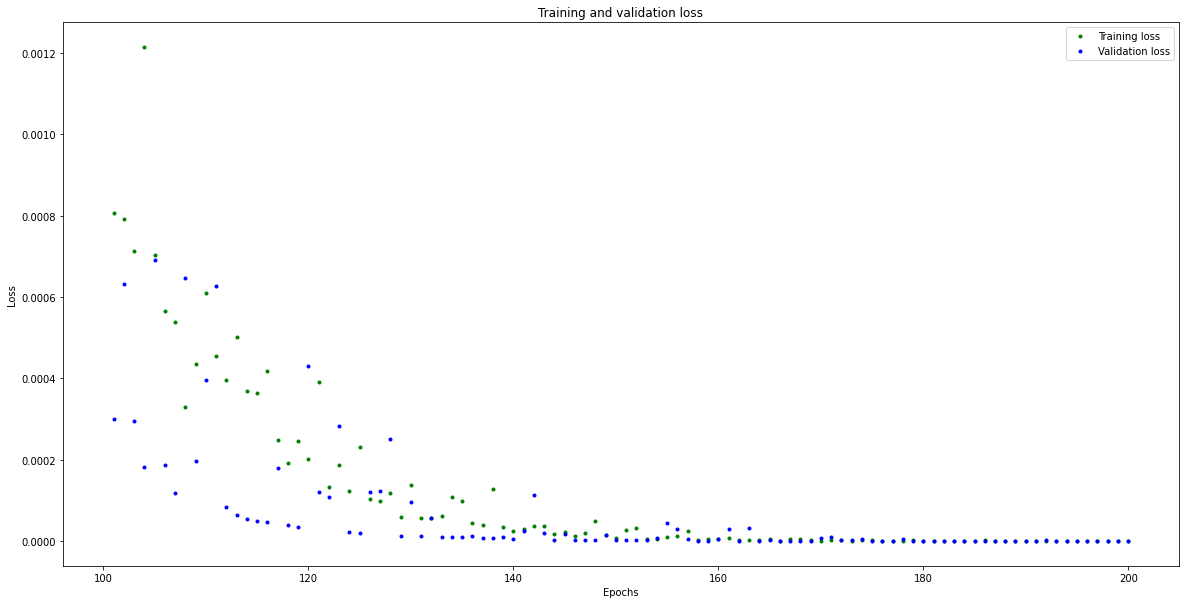

In [8]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

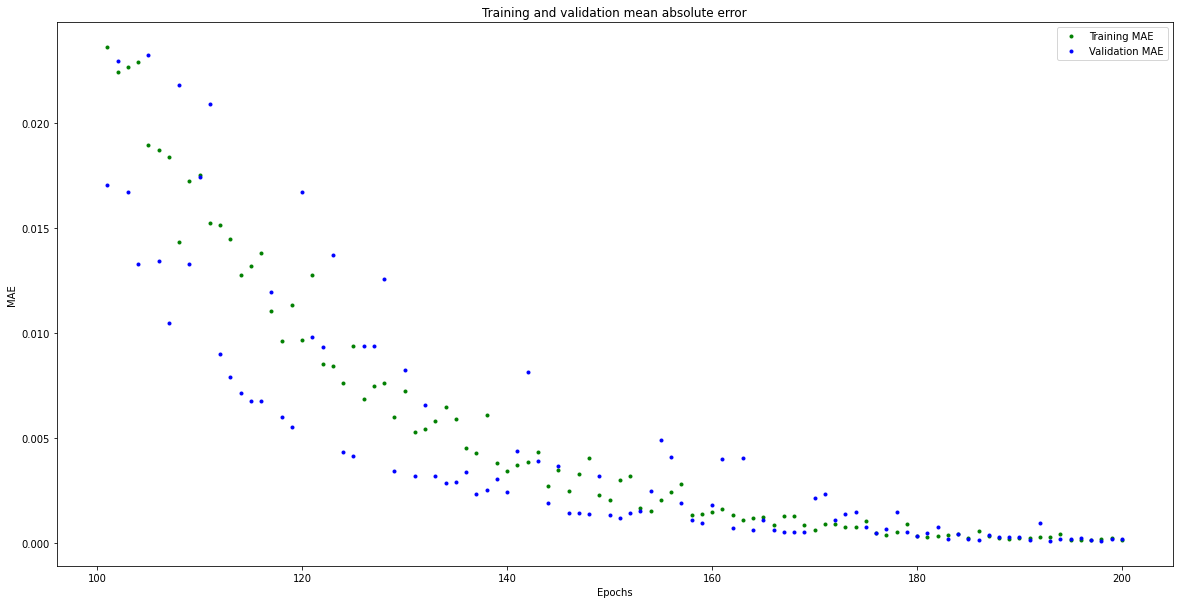

In [9]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [10]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
#plt.clf()
#plt.title('Training data predicted vs actual values')
#plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
#plt.plot(inputs_test, predictions, 'r.', label='Predicted')
#plt.show()

predictions =
 [[0.011 0.989]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]]
actual =
 [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


#Export weights in float format and export to a C header file

Now we have a Keras model, let try to get parameters from the model, and do calculation without tensorflow. So the code can be ported to Arduino easily.



In [11]:
print(model.summary())
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1510      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
Total params: 1,577
Trainable params: 1,577
Non-trainable params: 0
_________________________________________________________________
None
[array([[ 0.16572483,  0.19490913,  0.1095117 , ..., -0.02164063,
         0.13913998, -0.18999377],
       [ 0.05263432,  0.1026336 , -0.08846859, ..., -0.0881612 ,
        -0.16782255,  0.01483597],
       [ 0.08014707,  0.315751  ,  0.17811361, ...,  0.04241044,
         0.11138494,  0.03409518],
       ...,
       [-0.09300584,  0.2938859 ,  0.06175801, ..., -0.06997736,
 

##Here we get output of each layer of Keras model using the first test sample as input  

In [12]:
for i in range(len(model.layers)):
  intermediate_layer_model = tf.keras.Model(model.input, model.layers[i].output)
  intermediate_output = intermediate_layer_model.predict(inputs_test[0:1,:])
  print(intermediate_output)

[[2.1004243 9.132336  0.        0.7835185 0.        0.        0.9163014
  4.875319  0.9502537 0.       ]]
[[4.0752916 3.083268  0.        0.8873678 3.3958628]]
[[0.01097075 0.9890293 ]]


##Write code in pure python, and we should get the same result to the Keras output

In [13]:
layerCount = len(model.layers)
layerSize = [0]*(layerCount+1)
activationFunc = [0]*layerCount
activationFuncDict = {
  "linear": 0,
  "relu": 1,
  "softmax": 2
}

layerSize[0] = model.input.shape[1]
for i in range(layerCount):
  layerSize[i+1] = model.layers[i].output.shape[1]
  configInfo = model.layers[i].get_config()
  activationInfo = configInfo['activation']
  if activationInfo in activationFuncDict:
    activationFunc[i] = activationFuncDict[activationInfo]
  else:
    print("unknown activation func: "+activationInfo)
    raise KeyboardInterrupt

bufferIn = [0]*max(layerSize)
bufferOut = [0]*max(layerSize[1:])

#print( model.layers[1].get_weights() )
layerWeightArrays = [None]*layerCount
layerBaisArrays = [None]*layerCount
for i in range(layerCount):
  layerWeightInfo = model.layers[i].get_weights()
  layerWeightArrays[i] = layerWeightInfo[0].flatten('F').tolist()
  layerBaisArrays[i] = layerWeightInfo[1].tolist()

#load input value into buffer
for i in range(SAMPLES_PER_GESTURE*3):
  bufferIn[i] = inputs_test[0][i]

#to implement in Arduino
for layerIndex in range(layerCount):
  bufferInSize = layerSize[layerIndex]
  bufferOutSize = layerSize[layerIndex+1]
  layerBaisArray = layerBaisArrays[layerIndex]
  layerWeightArray = layerWeightArrays[layerIndex]

  weightCounter = 0
  for neuronIndex in range(bufferOutSize):
    s = 0
    for i in range(bufferInSize):
      #s = s+bufferIn[i]*layerWeight[0][i,neuronIndex]
      s += bufferIn[i]*layerWeightArray[weightCounter]
      weightCounter += 1
    s = s+layerBaisArray[neuronIndex]
    bufferOut[neuronIndex] = s

  if (activationFunc[layerIndex]==1):
    for neuronIndex in range(bufferOutSize):
      if (bufferOut[neuronIndex]<0):
        bufferOut[neuronIndex]=0
  elif (activationFunc[layerIndex]==2):
    s = 0;
    for neuronIndex in range(bufferOutSize):
      expOfValue = math.exp(bufferOut[neuronIndex])
      s+=expOfValue
      bufferOut[neuronIndex] = expOfValue
    s = 1.0/s
    for neuronIndex in range(bufferOutSize):
      bufferOut[neuronIndex] = bufferOut[neuronIndex]*s

  for neuronIndex in range(bufferOutSize):
    bufferIn[neuronIndex] = bufferOut[neuronIndex]

  print(bufferOut[0:bufferOutSize])
#compare output of this cell to previous cell, they should be the same.
#testFloatModelWithFixedSample should be the same as well.

[2.1004244611231115, 9.132335502440299, 0, 0.7835184823397867, 0, 0, 0.9163012594453903, 4.875319197788485, 0.9502538945853303, 0]
[4.075291789864611, 3.0832681566052442, 0, 0.8873679309918184, 3.3958628787873475]
[0.01097074678699024, 0.9890292532130098]


##Then we print all necessary parameters in C header file format

In [14]:
#generate header file for Arduino

print("//This version of code only support dense layer, with linear, relu or softmax activation function.\n")

print("#include <avr/pgmspace.h>")
print()
print("#define LAYER_COUNT          "+str(layerCount))
print()
print("const PROGMEM uint16_t layerSize[] = { "+(", ".join([str(i) for i in layerSize]))+" };")
print()
print("enum State { "+(", ".join([("AF_"+key+" = "+str(activationFuncDict[key])) for key in activationFuncDict.keys()]))+" };")
print()
print("const PROGMEM uint8_t activationFunc[] = { "+(", ".join([str(i) for i in activationFunc]))+" };")
print()
print("#define BUFFER_IN_SIZE          "+str(len(bufferIn)))
print("#define BUFFER_OUT_SIZE          "+str(len(bufferOut)))
print()
for j in range(layerCount):
  print("const float layerWeightArray"+str(j)+"[] PROGMEM = { "+(", ".join([str(i) for i in layerWeightArrays[j]]))+" };")
print("const float *const layerWeightArrays[] PROGMEM = {"+(", ".join([("layerWeightArray"+str(i)) for i in range(layerCount)]))+"};")
print()
for j in range(layerCount):
  print("const float layerBaisArray"+str(j)+"[] PROGMEM = { "+(", ".join([str(i) for i in layerBaisArrays[j]]))+" };")
print("const float *const layerBaisArrays[] PROGMEM = {"+(", ".join([("layerBaisArray"+str(i)) for i in range(layerCount)]))+"};")


//This version of code only support dense layer, with linear, relu or softmax activation function.

#include <avr/pgmspace.h>

#define LAYER_COUNT          3

const PROGMEM uint16_t layerSize[] = { 150, 10, 5, 2 };

enum State { AF_linear = 0, AF_relu = 1, AF_softmax = 2 };

const PROGMEM uint8_t activationFunc[] = { 1, 1, 2 };

#define BUFFER_IN_SIZE          150
#define BUFFER_OUT_SIZE          10

const float layerWeightArray0[] PROGMEM = { 0.16572482883930206, 0.05263432115316391, 0.08014707267284393, 0.3965612053871155, 0.07087141275405884, 0.019672637805342674, 0.4159057140350342, 0.12205254286527634, 0.012540251947939396, 0.21613648533821106, 0.06813231110572815, -0.04938127100467682, 0.3210355341434479, -0.028448961675167084, -0.10419117659330368, -0.1163090243935585, 0.104266457259655, 0.21282057464122772, 0.07798399031162262, -0.1126633882522583, 0.16375179588794708, 0.03052557073533535, 0.14147290587425232, -0.02299104817211628, -0.24627287685871124, 0.20146387815475464, -0.

#Go further to integer calculation for faster speed.

##Prepare a representative dataset

In [15]:
#prepare a representative dataset

representativeDataset = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  df = pd.read_csv("/content/" + gesture + ".csv")
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      tensor += [
          (df['aX'][index]),
          (df['aY'][index]),
          (df['aZ'][index]),
      ]

    representativeDataset.append(tensor)

# convert the list to numpy array
representativeDataset = np.array(representativeDataset, dtype=np.float32)

def representative_data_gen():
  for input_value in representativeDataset:
    yield [[input_value]]

Processing index 0 for gesture 'punch'.
	There are 10 recordings of the punch gesture.
Processing index 1 for gesture 'flex'.
	There are 10 recordings of the flex gesture.


##Convert tflite model

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()
open("arduino_model_quant_io.tflite", "wb").write(tflite_model)

3936

##Load model into interpreter, check input and output

In [17]:
interpreter = tf.lite.Interpreter(model_path="arduino_model_quant_io.tflite")
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])


== Input details ==
name: dense_input
shape: [  1 150]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 2]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'dense_input', 'index': 11, 'shape': array([  1, 150], dtype=int32), 'shape_signature': array([  1, 150], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'Identity', 'index': 12, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([1, 2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


##Check dataset and see if model is working

In [18]:


input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

for i in range(representativeDataset.shape[0]):
  interpreter.set_tensor(input_index, representativeDataset[i+0:i+1,:])
  interpreter.invoke()
  interpreterPredictions = interpreter.get_tensor(output_index)
  originalModelPredictions=model.predict((representativeDataset[i+0:i+1,:]+127)/256.0)
  print(interpreterPredictions,originalModelPredictions)




[[0.99609375 0.        ]] [[9.99887228e-01 1.12704154e-04]]
[[0.99609375 0.        ]] [[9.9989581e-01 1.0416365e-04]]
[[0.99609375 0.        ]] [[9.9987578e-01 1.2422618e-04]]
[[0.99609375 0.        ]] [[9.999075e-01 9.246926e-05]]
[[0.99609375 0.        ]] [[9.9974495e-01 2.5498332e-04]]
[[0.99609375 0.        ]] [[9.9985969e-01 1.4026086e-04]]
[[0.99609375 0.        ]] [[9.9986923e-01 1.3077217e-04]]
[[0.99609375 0.        ]] [[9.9987602e-01 1.2396491e-04]]
[[0.99609375 0.        ]] [[9.9987936e-01 1.2056936e-04]]
[[0.99609375 0.        ]] [[9.9988902e-01 1.1100086e-04]]
[[0.         0.99609375]] [[0.01097075 0.9890293 ]]
[[0.         0.99609375]] [[1.5103171e-04 9.9984896e-01]]
[[0.         0.99609375]] [[3.1585027e-05 9.9996841e-01]]
[[0.         0.99609375]] [[5.0163286e-05 9.9994981e-01]]
[[0.         0.99609375]] [[4.4917968e-05 9.9995506e-01]]
[[0.         0.99609375]] [[3.6212139e-05 9.9996376e-01]]
[[0.         0.99609375]] [[4.4684395e-05 9.9995530e-01]]
[[0.         0.99609

##load one model to test our algorithm

In [0]:
interpreter.set_tensor(input_index, representativeDataset[0:1,:])
interpreter.invoke()
interpreterPredictions = interpreter.get_tensor(output_index)



##show model detail

In [20]:
interpreter.get_tensor_details() 

[{'dtype': numpy.int8,
  'index': 0,
  'name': 'dense_input_int8',
  'quantization': (0.9960784316062927, -1),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.99607843], dtype=float32),
   'zero_points': array([-1], dtype=int32)},
  'shape': array([  1, 150], dtype=int32),
  'shape_signature': array([  1, 150], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.int32,
  'index': 1,
  'name': 'sequential/dense/BiasAdd/ReadVariableOp',
  'quantization': (0.0040348549373447895, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.00403485], dtype=float32),
   'zero_points': array([0], dtype=int32)},
  'shape': array([10], dtype=int32),
  'shape_signature': array([10], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.int32,
  'index': 2,
  'name': 'sequential/dense_1/BiasAdd/ReadVariableOp',
  'quantization': (0.009892069734632969, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array(

##show data in each tensor

In [21]:
all_layers_details = interpreter.get_tensor_details() 
for layer in all_layers_details:
  #  print(interpreter.get_tensor(layer))

     print(layer['index'],layer['name'],layer['quantization'],interpreter.get_tensor(layer['index']).shape)
     print(interpreter.get_tensor(layer['index']))


0 dense_input_int8 (0.9960784316062927, -1) (1, 150)
[[   0    0  127   63    0    0    0    0   -6  -47    0   -6  -44   -8
   -13  -17   -8  -27   14   -5  -17   42    4   14   49    1   -5   22
   -34  -51   49  -37  -37   92    9    5   92   36   60   69    8   60
    23    4   46   -9    7   32  -16    2  -31  -49  -22  -85  -46  -16
   -64  -39    2    7  -42    1   20  -46  -75 -119  -44  -19   -4  -47
    18    8  -44   29   26   -6    2   18   -3   -5   15    1  -17    8
     7    3    0   18   12    5   15    9    8   21    6    2   18   10
    -1   11    6  -12    4   -1  -13    4    3   -4    3    5    0    2
     2   -2   -2   -4   -7   -5   -5   -6   -3   -3   -6    0   -2   -2
    -1   -4  127 -128   -4    3    0    0   -2    5    0    0    2    0
     4    1    1    3   -1    0   -1   -2   -1   -3]]
1 sequential/dense/BiasAdd/ReadVariableOp (0.0040348549373447895, 0) (10,)
[ 4 30  0 -1  0  0  1 18  0 -1]
2 sequential/dense_1/BiasAdd/ReadVariableOp (0.009892069734632969,

##Download tflite file for Netron view

In [0]:
from google.colab import files
files.download('/content/arduino_model_quant_io.tflite')


##Using own python code to do full-connected layer

In [23]:
#use Netron viewer to understand model first, then adjust code to extract necessary data
#from Netron, we know the process is Quantize->FullyConnected(Relu)->FullyConnected(Relu)->FullyConnected->Softmax->Dequantize

layerCount = len(model.layers)
layerSize = [0]*(layerCount+1)

layerSize[0] = model.input.shape[1]
for i in range(layerCount):
  layerSize[i+1] = model.layers[i].output.shape[1]

layerWeightArrays = [None]*layerCount
layerBaisArrays = [None]*layerCount

modelInputSize = layerSize[0]

bufferIn = [0]*max(layerSize)
bufferOut = [0]*max(layerSize[1:])

inputLayerIndex = next(item for item in all_layers_details if item["name"] == (model.layers[0].name+"_input"))["index"]

quantizeIndex = next(item for item in all_layers_details if item["name"] == (model.layers[0].name+"_input_int8"))["index"]
quantizeInfo = all_layers_details[quantizeIndex]
quantizeZeroPoint = quantizeInfo["quantization_parameters"]["zero_points"][0]
quantizeScale = quantizeInfo["quantization_parameters"]["scales"][0]

inputTensorData = interpreter.tensor(inputLayerIndex)()
for i in range(modelInputSize):
  bufferIn[i]=int(inputTensorData[0][i])
print("load raw input:",bufferIn)

for i in range(modelInputSize):
  n = int(bufferIn[i]*(1.0/quantizeScale)+quantizeZeroPoint)
  if (n<-128):
    n=-128
  elif (n>127):
    n=127
  bufferIn[i]=n
print("Quantized Result:",bufferIn)

#just fetch name from Netron, that will be easier
inputLayerName = ['dense_input_int8','sequential/dense/Relu','sequential/dense_1/Relu']
weightLayerName = ['sequential/dense/MatMul','sequential/dense_1/MatMul','sequential/dense_2/MatMul']
biasLayerName = ['sequential/dense/BiasAdd/ReadVariableOp','sequential/dense_1/BiasAdd/ReadVariableOp','sequential/dense_2/BiasAdd/ReadVariableOp']
outputLayerName = ['sequential/dense/Relu','sequential/dense_1/Relu','sequential/dense_2/BiasAdd']

reduced_multipliers = [0]*layerCount
total_shifts = [0]*layerCount
inputZeroPoints = [0]*layerCount
weightZeroPoints = [0]*layerCount
outputZeroPoints = [0]*layerCount


#get tensor index for dense layers
for layerIndex in range(layerCount):
  #get all layers
  inputLayerIndex = next(item for item in all_layers_details if item["name"] == (inputLayerName[layerIndex]))["index"]
  inputLayerInfo = all_layers_details[inputLayerIndex]
  weightLayerIndex = next(item for item in all_layers_details if item["name"] == (weightLayerName[layerIndex]))["index"]
  weightLayerInfo = all_layers_details[weightLayerIndex]
  biasLayerIndex = next(item for item in all_layers_details if item["name"] == (biasLayerName[layerIndex]))["index"]
  biasLayerInfo = all_layers_details[biasLayerIndex]
  outputLayerIndex = next(item for item in all_layers_details if item["name"] == (outputLayerName[layerIndex]))["index"]
  outputLayerInfo = all_layers_details[outputLayerIndex]

  inputZeroPoint = inputLayerInfo["quantization_parameters"]["zero_points"][0]
  inputScale = inputLayerInfo["quantization_parameters"]["scales"][0]
  weightZeroPoint = weightLayerInfo["quantization_parameters"]["zero_points"][0]
  weightScale = weightLayerInfo["quantization_parameters"]["scales"][0]
  biasZeroPoint = biasLayerInfo["quantization_parameters"]["zero_points"][0]
  biasScale = biasLayerInfo["quantization_parameters"]["scales"][0]
  outputZeroPoint = outputLayerInfo["quantization_parameters"]["zero_points"][0]
  outputScale = outputLayerInfo["quantization_parameters"]["scales"][0]

  #In tensorflow repo kernel_util.cc GetQuantizedConvolutionMultipler
  realMultiplier = inputScale*weightScale/outputScale
  #in tensorflow repo quantization_util.cc QuantizeMultiplier
  if (realMultiplier == 0):
      quantized_multiplier=0
      shift = 0
  else:
      (q,shift) = math.frexp(realMultiplier)
      q_fixed = int(q*(1<<31))
      if (q_fixed == (1 << 31)):
        q_fixed /= 2;
        shift+=1
      if (shift < -31):
        shift = 0;
        q_fixed = 0;
      quantized_multiplier = q_fixed
  reduced_multipliers[layerIndex] = (quantized_multiplier + (1 << 15)) >> 16;
  total_shifts[layerIndex] = 15 - shift;

  inputZeroPoints[layerIndex] = inputZeroPoint
  weightZeroPoints[layerIndex] = weightZeroPoint
  outputZeroPoints[layerIndex] = outputZeroPoint

  weightData = interpreter.tensor(weightLayerIndex)()
  biasData = interpreter.tensor(biasLayerIndex)()

  layerWeightArrays[layerIndex] = weightData.flatten('C').tolist()
  layerBaisArrays[layerIndex] = biasData.tolist()

#real calculation
for layerIndex in range(layerCount):

  layerBaisArray = layerBaisArrays[layerIndex]
  layerWeightArray = layerWeightArrays[layerIndex]

  bufferInSize = layerSize[layerIndex]
  bufferOutSize = layerSize[layerIndex+1]

  inputZeroPoint = inputZeroPoints[layerIndex]
  weightZeroPoint = weightZeroPoints[layerIndex]
  outputZeroPoint = outputZeroPoints[layerIndex]
  reduced_multiplier = reduced_multipliers[layerIndex]
  total_shift = total_shifts[layerIndex]

  weightCounter = 0
  for neuronIndex in range(bufferOutSize):
    s = 0
    for i in range(bufferInSize):
      #s += (bufferIn[i]-inputZeroPoint)*(weightData[neuronIndex,i]+weightZeroPoint)
      s += (bufferIn[i]-inputZeroPoint)*(layerWeightArray[weightCounter]-weightZeroPoint)
      #s += bufferIn[i]*layerWeightArray[weightCounter]
      weightCounter += 1
    s = (int(s+layerBaisArray[neuronIndex]))
    #in tensorflow repo common.h MultiplyByQuantizedMultiplier
    #print(s)
    
    x=s
    x = (x * reduced_multiplier) + (1 << (total_shift - 1));
    result = x >> total_shift
    s=result
    #print(s)
    s+=outputZeroPoint;

    
    #CalculateActivationRange: std::numeric_limits<T>::lowest()~std::numeric_limits<T>::max(). For int8_t, that is always -128~127
    if (s<-128):
      s=-128
    elif (s>127):
      s=127
    #print("!!!",s)

    bufferOut[neuronIndex] = (s)

  for neuronIndex in range(bufferOutSize):
    bufferIn[neuronIndex] = bufferOut[neuronIndex]

  print('layer'+str(layerIndex)+'Out',bufferOut[0:bufferOutSize])

#skip softmax because it is not important for getting most likely class



load raw input: [-21, -3, 19, -26, -1, 9, -28, 0, -5, -46, 1, -5, -43, -7, -12, -16, -7, -26, 15, -4, -16, 43, 5, 15, 50, 2, -4, 23, -33, -50, 50, -36, -36, 93, 10, 6, 93, 37, 61, 70, 9, 61, 24, 5, 47, -8, 8, 33, -15, 3, -30, -48, -21, -84, -45, -15, -63, -38, 3, 8, -41, 2, 21, -45, -16, 8, -43, -18, -3, -46, 19, 9, -43, 30, 27, -5, 3, 19, -2, -4, 16, 2, -16, 9, 8, 4, 1, 19, 13, 6, 16, 10, 9, 22, 7, 3, 19, 11, 0, 12, 7, -11, 5, 0, -12, 5, 4, -3, 4, 6, 1, 3, 3, -1, -1, -3, -6, -4, -4, -5, -2, -2, -5, 1, -1, -1, 0, -3, 3, -1, -3, 4, 1, 1, -1, 6, 1, 1, 3, 1, 5, 2, 2, 4, 0, 1, 0, -1, 0, -2]
Quantized Result: [-22, -4, 18, -27, -2, 8, -29, -1, -6, -47, 0, -6, -44, -8, -13, -17, -8, -27, 14, -5, -17, 42, 4, 14, 49, 1, -5, 22, -34, -51, 49, -37, -37, 92, 9, 5, 92, 36, 60, 69, 8, 60, 23, 4, 46, -9, 7, 32, -16, 2, -31, -49, -22, -85, -46, -16, -64, -39, 2, 7, -42, 1, 20, -46, -17, 7, -44, -19, -4, -47, 18, 8, -44, 29, 26, -6, 2, 18, -3, -5, 15, 1, -17, 8, 7, 3, 0, 18, 12, 5, 15, 9, 8, 21, 6, 2,

##Then we print all necessary parameters in C header file format

In [24]:
#generate header file for Arduino

print("//This version of code only support TFLite dense layer\n")

print("#include <avr/pgmspace.h>")
print()
print("#define LAYER_COUNT          "+str(layerCount))
print()
print("const PROGMEM uint16_t layerSize[] = { "+(", ".join([str(i) for i in layerSize]))+" };")
print()
print("#define BUFFER_IN_SIZE          "+str(len(bufferIn)))
print("#define BUFFER_OUT_SIZE          "+str(len(bufferOut)))
print()
print("#define QUANTIZE_ZERO_POINT          "+str(quantizeZeroPoint))
print("#define QUANTIZE_SCALE          "+str(quantizeScale))
print()
for j in range(layerCount):
  print("const int8_t layerWeightArray"+str(j)+"[] PROGMEM = { "+(", ".join([str(i) for i in layerWeightArrays[j]]))+" };")
print("const int8_t *const layerWeightArrays[] PROGMEM = {"+(", ".join([("layerWeightArray"+str(i)) for i in range(layerCount)]))+"};")
print()
for j in range(layerCount):
  print("const int8_t layerBaisArray"+str(j)+"[] PROGMEM = { "+(", ".join([str(i) for i in layerBaisArrays[j]]))+" };")
print("const int8_t *const layerBaisArrays[] PROGMEM = {"+(", ".join([("layerBaisArray"+str(i)) for i in range(layerCount)]))+"};")
print()
print("const int32_t inputZeroPoints"+"[] PROGMEM = { "+(", ".join([str(i) for i in inputZeroPoints]))+" };")
print("const int32_t weightZeroPoints"+"[] PROGMEM = { "+(", ".join([str(i) for i in weightZeroPoints]))+" };")
print("const int32_t outputZeroPoints"+"[] PROGMEM = { "+(", ".join([str(i) for i in outputZeroPoints]))+" };")
print("const int32_t reduced_multipliers"+"[] PROGMEM = { "+(", ".join([str(i) for i in reduced_multipliers]))+" };")
print("const uint8_t total_shifts"+"[] PROGMEM = { "+(", ".join([str(i) for i in total_shifts]))+" };")

//This version of code only support TFLite dense layer

#include <avr/pgmspace.h>

#define LAYER_COUNT          3

const PROGMEM uint16_t layerSize[] = { 150, 10, 5, 2 };

#define BUFFER_IN_SIZE          150
#define BUFFER_OUT_SIZE          10

#define QUANTIZE_ZERO_POINT          -1
#define QUANTIZE_SCALE          0.99607843

const int8_t layerWeightArray0[] PROGMEM = { 41, 13, 20, 98, 17, 5, 103, 30, 3, 53, 17, -12, 79, -7, -26, -29, 26, 53, 19, -28, 40, 8, 35, -6, -61, 50, -25, -95, 27, -65, -91, -38, -34, -63, -10, -74, -104, 3, -15, -46, 17, -62, -76, 7, -25, 26, -36, -24, 7, 13, 3, 63, -11, 57, -10, 27, 53, 35, 48, 48, 14, -5, 54, 60, -8, 27, 54, -15, -35, 79, 30, 27, 87, -9, -41, -5, -17, 39, 24, 29, 39, 9, 45, -26, 10, -33, 22, 38, 37, -5, 58, 43, -19, 14, 4, 4, -31, 26, 59, 35, -44, 21, -15, -37, 43, -39, -51, 28, 11, -25, 7, 27, 57, -25, 22, -7, -20, 11, -2, -20, 25, 10, 23, 5, -10, -30, 47, 46, 5, 5, -2, 20, 21, 23, 0, -2, -31, 5, 13, -8, 27, 11, -11, 32, -14, -21, 25, -23, 